# Fig 3 Deriving and validation a multivariate neurological signature of of nociplastic pain

### This notebook contains the analyses code for figure 3:
- Calculate and plot the overlapping sample sizes for the 3 nociplastic conditions (fibromyalgia, chronic fatigue syndrome, and chronic widespread pain)
- Calculate and plot the deviance explained for models trained to predict fibromyalgia based on brain, psychosocial, and their union
- Calculate and plot the deviance explained for models trained to predict chronic pain based on blood/brain, psychosocial, and their union

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import zscore
from scipy import stats
import palettable
from sklearn.metrics import roc_auc_score
import nibabel as nib
from nilearn.connectome import vec_to_sym_matrix
from sklearn.preprocessing import MaxAbsScaler

home_dir = '/Users/Patty/Desktop/EVP_lab/'

fs = 8
w = 0.5
sns.set_context(rc={"font.size":fs})   
plt.rcParams['font.size'] = fs
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['figure.dpi'] = 300
plt.rc('mathtext',**{'default':'regular'})
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5
plt.rcParams['xtick.major.pad'] = '1.5'
plt.rcParams['ytick.major.pad'] = '1.5'
plt.rcParams['xtick.major.width'] = w
plt.rcParams['ytick.major.width'] = w
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.pad'] = '1.5'
plt.rcParams['ytick.minor.pad'] = '1.5'
plt.rcParams['xtick.minor.width'] = w
plt.rcParams['ytick.minor.width'] = w
plt.rcParams['axes.linewidth'] = w
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']

# Pastel2
color_mapping = {
 'Blood': '#9EB9F3',
 'Bone': '#F89C74',
 'PRS': '#DCB0F2',
 'Stacked': '#87C55F',
 'Psychosocial': '#C0BFC9'}


In [2]:
# Load machine learning models trained to predict nociplastic conditions
noci = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/Nociplastic/Nociplastic_diagnoses_clf-LR_lin.pickle')

In [3]:
# Load in necessary UKB data
home_dir = '/Users/Patty/Desktop/EVP_lab/'

cols = ['eid', 
        # T0
        'ChronicPain_T0',
        'ChronicWidespreadPain_T0', 
        'ChronicHeadaches_T0',
        'ChronicNeckShoulderPain_T0', 
        'ChronicHipPain_T0', 
        'ChronicBackPain_T0', 
        'ChronicStomachAbdominalPain_T0', 
        'ChronicKneePain_T0',
        'ChronicFacialPain_T0', 
        'NumberChronicPainTypes_T0',
        # T1
        'ChronicWidespreadPain_T1', 
        'NumberChronicPainTypes_T1',
        # T2
        'ChronicPain_T2',
        'ChronicWidespreadPain_T2', 
        'ChronicHeadaches_T2',
        'ChronicNeckShoulderPain_T2', 
        'ChronicHipPain_T2', 
        'ChronicBackPain_T2', 
        'ChronicStomachAbdominalPain_T2', 
        'ChronicKneePain_T2',
        'ChronicFacialPain_T2', 
        'NumberChronicPainTypes_T2',
        'NumberReportedNonCancer_T0',
        'NumberReportedNonCancer_T1',
        'NumberReportedNonCancer_T2',
       # Impact
        'OverallHealthRating_T0',
        'UnableWorkDueSicknessDisability_T0',
        'OverallHealthRating_T2',
        'UnableWorkDueSicknessDisability_T2',
       # Additional
       'Age_T0',
        'Age_T1',
       'Age_T2',
       'Sex_T0']
UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=cols) #UKB demographic data
UKB = UKB.drop(columns=UKB.filter(like='T0').columns[113:172])
UKB.loc[UKB['ChronicWidespreadPain_T0'] == 1, 'NumberChronicPainTypes_T0'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T0'] > 4, 'NumberChronicPainTypes_T0'] = 4
UKB.loc[UKB['ChronicWidespreadPain_T1'] == 1, 'NumberChronicPainTypes_T1'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T1'] > 4, 'NumberChronicPainTypes_T1'] = 4
UKB.loc[UKB['ChronicWidespreadPain_T2'] == 1, 'NumberChronicPainTypes_T2'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T2'] > 4, 'NumberChronicPainTypes_T2'] = 4

# NCI Data
NCI = pd.read_csv(home_dir + 'NCI_combined.csv')

#Only take UKB eids in brain eids
UKB = UKB.merge(NCI,on='eid')

UKB['NCI_Free_T0'] = np.where(UKB.NCI_T0 == 0,1,0)
UKB['NCI_Free_T1'] = np.where(UKB.NCI_T1 == 0,1,0)
UKB['NCI_Free_T2'] = np.where(UKB.NCI_T2 == 0,1,0)
UKB['NCI_Free_T3'] = np.where(UKB.NCI_T3 == 0,1,0)

## Nociplastic Venn diagram

In [5]:
# Extract subjects with nociplastic pain conditions
noci_eids = pd.concat([pd.DataFrame(noci[i]['roc_curve'],index=['eid','y','prob']) for i in noci.keys() if 'Nociplastic_Stacked' in i],axis=1).T.eid
NCI_noci = NCI[['eid','NCI_fibromyalgia_T2','NCI_chronic fatigue syndrome_T2']].merge(UKB[['eid','ChronicWidespreadPain_T2']])
NCI_noci = NCI_noci[NCI_noci.eid.isin(noci_eids)]

# Filter UKB by subjects with brain imaging data
eids = pd.read_csv('/Users/Patty/Desktop/EVP_lab/NonBio_T0.csv',usecols=['eid'])
UKB = UKB[UKB.eid.isin(eids.eid)]

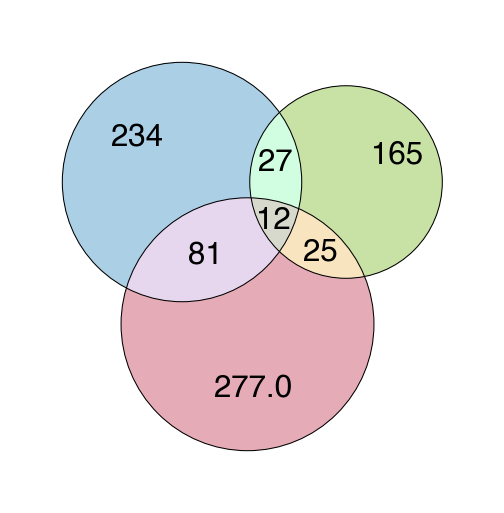

In [9]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the counts for each condition
fibromyalgia_count = NCI_noci['NCI_fibromyalgia_T2'].sum()
chronic_fatigue_syndrome_count = NCI_noci['NCI_chronic fatigue syndrome_T2'].sum()
widespread_pain_count = NCI_noci['ChronicWidespreadPain_T2'].sum()

# Calculate the intersections
fibro_and_fatigue = NCI_noci[(NCI_noci['NCI_fibromyalgia_T2'] == 1) & (NCI_noci['NCI_chronic fatigue syndrome_T2'] == 1)].shape[0]
fibro_and_pain = NCI_noci[(NCI_noci['NCI_fibromyalgia_T2'] == 1) & (NCI_noci['ChronicWidespreadPain_T2'] == 1)].shape[0]
fatigue_and_pain = NCI_noci[(NCI_noci['NCI_chronic fatigue syndrome_T2'] == 1) & (NCI_noci['ChronicWidespreadPain_T2'] == 1)].shape[0]

# Calculate the intersection of all three conditions
all_three = NCI_noci[(NCI_noci['NCI_fibromyalgia_T2'] == 1) & (NCI_noci['NCI_chronic fatigue syndrome_T2'] == 1) & (NCI_noci['ChronicWidespreadPain_T2'] == 1)].shape[0]


# Create the Venn diagram
fig = plt.figure(figsize=(1.75, 1.75))
venn = venn3(subsets=(fibromyalgia_count, chronic_fatigue_syndrome_count, fibro_and_fatigue,
                      widespread_pain_count, fibro_and_pain, fatigue_and_pain, all_three),
                     set_colors=('#59A2CF', '#91C64A', '#CD5A70'),
                     # set_colors=('#4DBEEE', '#77AC30', '#A11731'),
                     set_labels=('', '', ''),
                     alpha=.5,
            )
c = venn3_circles(subsets=(fibromyalgia_count, chronic_fatigue_syndrome_count, fibro_and_fatigue,
                            widespread_pain_count, fibro_and_pain, fatigue_and_pain, all_three),
                            linewidth=.25, color = 'k',
)

# Customizing the colors
# venn.get_patch_by_id('100').set_color('skyblue')
# venn.get_patch_by_id('010').set_color('lightgreen')
# venn.get_patch_by_id('001').set_color('lightcoral')

# Customizing the text
for text in venn.set_labels:
    text.set_fontsize(0)
for text in venn.subset_labels:
    text.set_fontsize(7.5)

# Adjust the plot to ensure everything fits without overlapping
plt.tight_layout()
plt.show()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_3_Nociplastic/Noci_venn.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')

# Extract structure coefficients from nociplastic condition models

In [11]:
home_dir = '/Users/Patty/Desktop/EVP_lab/'
maps_dir = '/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Maps/'
plots_dir = '/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/'

fan = nib.load(home_dir+'Fan_et_al_atlas_r279_MNI_3mm_V2.nii')
nodes = pd.read_csv(home_dir + 'Fan_Cluster_279_Details_V2.csv')
edges = pd.read_csv(home_dir + 'Fan_Cluster_279_Edges_Details_V2.csv')


In [19]:
# Model results for each condition and combined conditions
fibro = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'fibromyalgia_fMRI' in i]).groupby(level=0,sort=False).mean()
CFS = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'syndrome_fMRI' in i]).groupby(level=0,sort=False).mean()
WSP = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Pain_fMRI' in i]).groupby(level=0,sort=False).mean()
nociplast = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Nociplastic_fMRI' in i]).groupby(level=0,sort=False).mean()

# Combine results
tmp = pd.concat([noci[i]['results_df'] for i in noci.keys() if 'Nociplastic' in i])
tmp.index = [i[:-4] for i in tmp.index]
tmp = tmp[~tmp.index.str.contains('ToPS')]

/var/folders/fd/xlhv7rgs74738n6159bs595w0000gn/T/ipykernel_58106/1950998022.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Category', y='AUC_test', data=df_reset, ci='sd', palette='viridis', ax=ax)
/var/folders/fd/xlhv7rgs74738n6159bs595w0000gn/T/ipykernel_58106/1950998022.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='AUC_test', data=df_reset, ci='sd', palette='viridis', ax=ax)
/var/folders/fd/xlhv7rgs74738n6159bs595w0000gn/T/ipykernel_58106/1950998022.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['T1','DWI','fMRI','All'])  # This removes the x-ticks


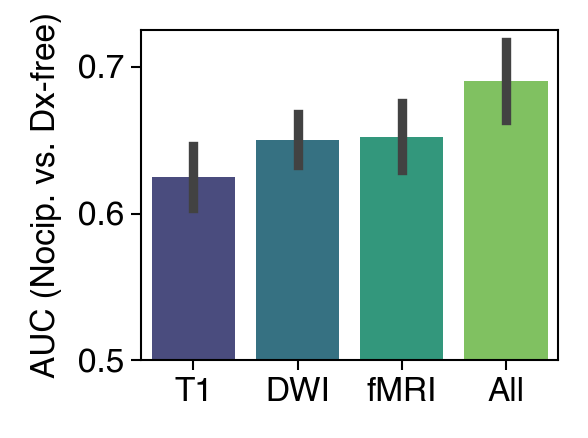

In [20]:
df = tmp[['AUC_test']]

# Assuming your DataFrame is named df and looks like the one you described
# First, reset the index to convert the index into a regular column
df_reset = df.reset_index()

# Rename columns for clarity
df_reset.columns = ['Category', 'AUC_test']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(2, 1.5))  # Adjust the size as needed

# Create the seaborn barplot on the specified axis (ax)
sns.barplot(x='Category', y='AUC_test', data=df_reset, ci='sd', palette='viridis', ax=ax)

# Set y-axis limits
ax.set_ylim(0.5, 0.725)
ax.set_yticks([0.5,0.6,0.7])

# Optional: Improve plot aesthetics
ax.set_xticklabels(['T1','DWI','fMRI','All'])  # This removes the x-ticks
ax.set_title('')
ax.set_ylabel('')
ax.set_ylabel('AUC (Nocip. vs. Dx-free)')
ax.set_xlabel('')

# Show the plot
plt.tight_layout()  # Adjust subplot parameters for a better fit
plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_3_Nociplastic/noci_bars.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')


# Validate the nociplastic pain signature in an external dataset OpenPain (n=250)

In [26]:
# Load OpenPain brain data
OP = pd.read_csv('/Users/Patty/Desktop/OpenPain/DCC_CSV/DCC_Full.csv')
OP = OP[(OP['Study'] != 'Placebo_OA') & (OP['Study'] != 'Resting')]
OP = OP.fillna(OP.mean())

# Recode study site variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
OP['Study_int'] = label_encoder.fit_transform(OP['Study'])

# Regress out confounds: head motion, age, gender, study site
from confounds import Residualize
resid = Residualize()
resid.fit(zscore(OP[nociplast.index]), OP[['Motion','age','gender','Study_int']])
OP[nociplast.index] = resid.transform(zscore(OP[nociplast.index]), OP[['Motion','age','gender','Study_int']])

/var/folders/fd/xlhv7rgs74738n6159bs595w0000gn/T/ipykernel_58106/2650557702.py:2: DtypeWarning: Columns (38781,38787) have mixed types. Specify dtype option on import or set low_memory=False.
  OP = pd.read_csv('/Users/Patty/Desktop/OpenPain/DCC_CSV/DCC_Full.csv')
/var/folders/fd/xlhv7rgs74738n6159bs595w0000gn/T/ipykernel_58106/2650557702.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  OP = OP.fillna(OP.mean())


Text(0.5, 1.0, '')

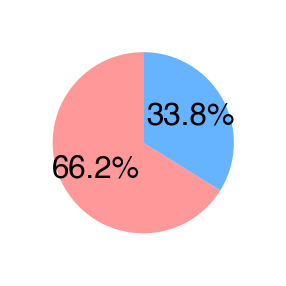

In [28]:
pain_type_counts = OP.PainType.value_counts()

# Create the pie chart
fig = plt.figure(figsize=(1, 1))  # Adjust the figure size as needed
plt.pie(pain_type_counts, labels=None, autopct='%1.1f%%', startangle=90, 
        colors=['#ff9999','#66b3ff'], textprops={'fontsize': 7.5})
plt.title('')

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_3_Nociplastic/OP_pain_pie.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')

## Calculate and plot nociplastic signature performance vs ToPS signature performance in OpenPain. Also plot null model from 1000 random shuffled permutations

/var/folders/fd/xlhv7rgs74738n6159bs595w0000gn/T/ipykernel_58106/1154414299.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(thresholds[::-1])


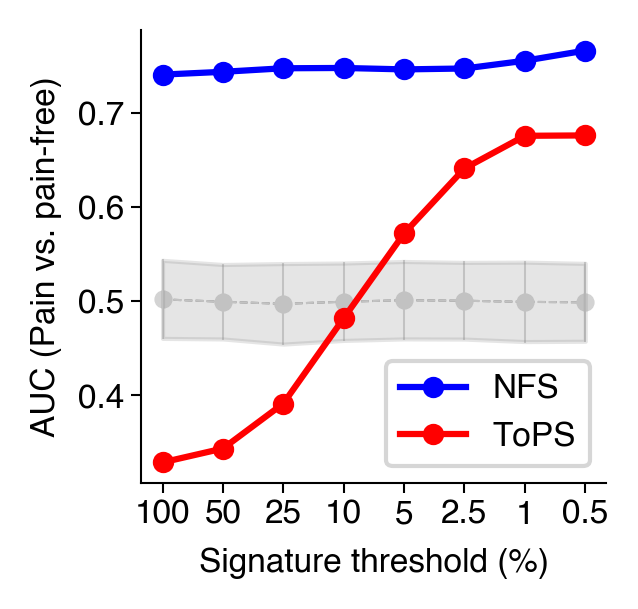

In [59]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import zscore

def compute_auc(OP, weights, threshold, column_name):
    # Threshold the weights
    thresholded_weights = threshold_w(weights, threshold)
    # Compute signature
    OP[column_name] = np.dot(zscore(OP[weights.index]), thresholded_weights)
    # Compute AUC
    return roc_auc_score(OP['ChronicPain'], OP[column_name])

def threshold_w(w, threshold):
    thresh = 100 - threshold
    w = np.where(abs(w) > np.percentile(abs(w), thresh), w, 0)
    return w


H = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Nociplastic_fMRI' in i]).groupby(level=0,sort=False).mean()
tops_w = scipy.io.loadmat('/Users/Patty/Desktop/ToPS/ToPS_weight.mat')['ToPS_w'].T[0]
tops_w_df = pd.DataFrame(tops_w,index=edges.names,columns=['ToPS'])

n_permutations = 1000  # Number of permutations
thresholds = [0.5, 1, 2.5, 5, 10, 25, 50, 100]  # From 1% to 100%
permuted_auc_scores = []  # To store the permuted AUC scores

for t in thresholds:
    # Threshold the weights for the current threshold
    thresholded_weights = threshold_w(H, t)
    OP['H_t'] = np.dot(zscore(OP[H.index]), thresholded_weights)
    X_t = OP['H_t']
    
    for _ in range(n_permutations):
        # Shuffle the labels
        y_shuffled = np.random.permutation(OP.ChronicPain)

        # Compute AUC score between the shuffled target and the single feature
        auc_score = roc_auc_score(y_shuffled, X_t)
        permuted_auc_scores.append({'Threshold': t, 'Permuted_AUC': auc_score})
permuted_auc_df = pd.DataFrame(permuted_auc_scores)

# 'OP' is pain DataFrame and 'H' and 'tops_w' are your weight vectors
thresholds = [0.5, 1, 2.5, 5, 10, 25, 50, 100]  # From 1% to 100%
auc_scores_H = []
auc_scores_tops = []

for t in thresholds:
    auc_H = compute_auc(OP, H, t, 'H')
    auc_tops = compute_auc(OP, tops_w_df, t, 'tops')
    auc_scores_H.append(auc_H)
    auc_scores_tops.append(auc_tops)

# Creating a DataFrame for plotting
thresholds_df = pd.DataFrame({
    'Threshold': thresholds,
    'AUC_H': auc_scores_H,
    'AUC_tops': auc_scores_tops
})

thresholds_df = thresholds_df.sort_values('Threshold', ascending=False)
thresholds_df['Threshold'] = thresholds_df['Threshold'].astype(str)
permuted_auc_df['Threshold'] = permuted_auc_df['Threshold'].astype(str)

# Plotting
fig, ax = plt.subplots(figsize=(2, 2))
sns.pointplot(x='Threshold', y='AUC_H', data=thresholds_df, color='blue', label='NFS', markersize=4, linewidth=1.5, ax=ax)
sns.pointplot(x='Threshold', y='AUC_tops', data=thresholds_df, color='red', label='ToPS', markersize=4, linewidth=1.5, ax=ax)
sns.pointplot(x='Threshold',y='Permuted_AUC', data=permuted_auc_df, errorbar='sd', linestyle='--', color='lightgrey', markersize=4, linewidth=.5, zorder=-10, ax=ax)
sns.lineplot(x='Threshold',y='Permuted_AUC', data=permuted_auc_df, errorbar='sd', linestyle='--', linewidth=.5, color='grey', zorder=-15, ax=ax)
ax.set_xlabel('Signature threshold (%)')
ax.set_ylabel('AUC (Pain vs. pain-free)')
# ax.axhline(.5,linestyle='--',lw=.5,color='k',zorder=-10)
ax.set_xticklabels(thresholds[::-1])
# plt.gca().invert_xaxis()  # Invert the x-axis
sns.despine()

plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_3_Nociplastic/OP_validation.pdf", 
#         dpi=300, transparent=True, bbox_inches='tight')


### Subacute sessions

In [ ]:
import pandas as pd

# Load the provided CSV file
file_path = '/Users/Patty/Desktop/OpenPain/Subacute/Subacute_sessions_merged.csv'
data = pd.read_csv(file_path)

subac = OP[OP['Study'].str.contains('Subacute')]
sub = [i for i in subac[subac['ChronicPain'] == 1].ID]
visit = [i.split('_')[1] for i in subac[subac['ChronicPain'] == 1].Study]
subjects_sessions = pd.DataFrame([sub,visit]).T.values

# Correcting the filter to ensure we get one row per subject-session pair as requested
filtered_data_corrected = pd.DataFrame()

# Iterating through the subject-session pairs and appending the matched row to the new dataframe
for subject, session in subjects_sessions:
    matched_row = data[(data['eid'] == subject) & (data['session_id'] == session)]
    filtered_data_corrected = filtered_data_corrected.append(matched_row)
    
filtered_data_corrected['mpq_radiculopathy'].astype(float).hist()

# This code is used to extract structure coefficients of the nociplastic signature and save them as a matlab file for plotting the circos plot in matlab

In [1676]:
brain_fc = pd.read_csv(home_dir + 'DCC_full' + '.csv',nrows=1000)  # FC method 


In [ ]:
import pandas as pd
import numpy as np

# Assuming you have the following dataframes:
# df_weights: A dataframe with a single column of feature weights
# df_features: A dataframe with feature values for each subject (rows are subjects, columns are features)

# Calculate the covariance matrix of the features
cov_matrix = df_features.cov()

# Ensure df_weights is a numpy array for matrix multiplication
weights = df_weights.values

# Compute the Haufe transform of the weights
haufe_transformed_weights = np.dot(cov_matrix, weights)

# Convert the result back to a dataframe if needed
df_haufe_transformed_weights = pd.DataFrame(haufe_transformed_weights, index=df_weights.index, columns=['Transformed Weights'])

# Output the transformed weights
print(df_haufe_transformed_weights)


In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
log_prob_tr = np.log(prob_tr / (1-prob_tr))
w = [np.cov(i, log_prob_tr)[0,1] for i in X_train.T]
hauf = pd.DataFrame(w,index=feature_labels,columns=['Haufe'])

feat_imp.append(importances)
feat_imp.append(hauf)

In [ ]:
cov_matrix = X_train.cov()
weights = importances.values
haufe_weights = np.dot(cov_matrix, weights)
haufe_weights_df = pd.DataFrame(haufe_weights, index=importances.index, columns=['Haufe'])


In [145]:
fibro = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'fibromyalgia_fMRI' in i]).groupby(level=0,sort=False).mean()
CFS = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'syndrome_fMRI' in i]).groupby(level=0,sort=False).mean()
WSP = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Pain_fMRI' in i]).groupby(level=0,sort=False).mean()
nociplast = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Nociplastic_fMRI' in i]).groupby(level=0,sort=False).mean()


In [146]:
from scipy.io import savemat

mat_data = {col_name: fibro[col_name].values.reshape(-1,1) for col_name in fibro.columns}
savemat('/Users/Patty/Documents/MATLAB/ToPS/fibro_loadings.mat', mat_data)

mat_data = {col_name: fibro[col_name].values.reshape(-1,1) for col_name in CFS.columns}
savemat('/Users/Patty/Documents/MATLAB/ToPS/CFS_loadings.mat', mat_data)

mat_data = {col_name: fibro[col_name].values.reshape(-1,1) for col_name in WSP.columns}
savemat('/Users/Patty/Documents/MATLAB/ToPS/WSP_loadings.mat', mat_data)

mat_data = {'loading': nociplast[col_name].values.reshape(-1,1) for col_name in nociplast.columns}
savemat('/Users/Patty/Documents/MATLAB/ToPS/noci_loadings.mat', mat_data)

## Positive vs. Negative loadings donut plot

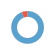

In [230]:
fig,ax = plt.subplots(figsize=(.75,.75))

pos = (WSP > 0).sum() / WSP.shape[0]
neg = 1-pos
data = np.stack([pos,neg]).flatten()
    
# create data
names = ['Positive', 'Negative']

# Create a circle at the center of the plot

pie_colors = ['#f6553d','#59a2cf']

# Custom wedges
ax.pie(data, labels=None, colors=pie_colors,
                   wedgeprops = { 'width' : .35, 'edgecolor' : 'grey', 'linewidth':.1},
                   startangle=90,
         )
    
fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_3_Nociplastic/WSP_pie.pdf", 
    dpi=300, transparent=True, bbox_inches='tight')

## Code to write node-average connectivity of nociplastic signatures to file for brain rendering using Surfice

In [242]:
fibro = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'fibromyalgia_fMRI' in i]).groupby(level=0,sort=False).mean()
CFS = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'syndrome_fMRI' in i]).groupby(level=0,sort=False).mean()
WSP = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Pain_fMRI' in i]).groupby(level=0,sort=False).mean()
nociplast = pd.concat([noci[i]['weights'][1] for i in noci.keys() if 'Nociplastic_fMRI' in i]).groupby(level=0,sort=False).mean()


In [267]:
thresh_w = threshold_w(nociplast.loadings,25)

thresh_w = threshold_w(fibro.loadings,25)

matrix = vec_to_sym_matrix(thresh_w, diagonal = np.repeat(0,279))
matrix_main = pd.DataFrame(matrix,columns=nodes.fc_networks)

dat = np.nansum(matrix_main, axis=1)
ID = np.arange(1,280)
dico_remap = dict(zip(ID,dat))

data = fan.get_fdata()
for i in ID:
    data = np.where(data == i, dico_remap[i], data)
nib.Nifti1Image(data, fan.affine).to_filename(maps_dir + 'Cortical_fan_W.nii.gz')

In [240]:
### SURF-ICE PLOTTING
#Cortical Left Side

import gl
gl.resetdefaults()

import gl
gl.resetdefaults()
name = 'fibro' # either fibro, CFS, WSP, or noci
min_c = -2
max_c = 0

import os
# Light blue, Light red version
fnm = os.path.expanduser("~")+os.path.sep+'myLUT.clut';
f = open(fnm, "w")
f.write("[INT]\n")
f.write("numnodes=5\n")
f.write("[BYT]\n")
f.write("nodeintensity0=20\n")
f.write("nodeintensity1=100\n")
f.write("nodeintensity2=255\n")
f.write("[RGBA255]\n")
f.write("nodergba0=255|255|255|255\n")
f.write("nodergba1=153|204|255|128\n")
f.write("nodergba2=0|128|255|128\n")
f.close()

#Cortical Right Side
gl.meshload('BrainMesh_ICBM152_smoothed.rh.mz3')
gl.overlayload('/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Maps/Cortical_fan_W.nii.gz')
gl.overlaycolorname(1,fnm)
gl.overlayinvert(1, 1)
gl.overlayminmax(1,min_c,max_c)
gl.colorbarvisible(False)
gl.orientcubevisible(False)
gl.shaderadjust('SpecularRough',0)
gl.bmpzoom(2)
gl.viewsagittal(1)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_R_Lat_Fan_Cortical_W.png')

ModuleNotFoundError: No module named 'gl'

In [1106]:
### SURF-ICE PLOTTING
#Cortical Left Side

# import gl
# gl.resetdefaults()

# name = 'noci' # either fibro, CFS, WSP, or noci
# min_c = -2
# max_c = 2

# import os
# # Light blue, Light red version
# fnm = os.path.expanduser("~")+os.path.sep+'myLUT.clut';
# f = open(fnm, "w")
# f.write("[INT]\n")
# f.write("numnodes=5\n")
# f.write("[BYT]\n")
# f.write("nodeintensity0=0\n")
# f.write("nodeintensity1=100\n")
# f.write("nodeintensity2=128\n")
# f.write("nodeintensity3=160\n")
# f.write("nodeintensity4=255\n")
# f.write("[RGBA255]\n")
# f.write("nodergba0=255|51|51|128\n")
# f.write("nodergba1=255|153|153|128\n")
# f.write("nodergba2=255|255|255|255\n")
# f.write("nodergba3=153|204|255|128\n")
# f.write("nodergba4=0|128|255|128\n")
# f.close()

import gl
gl.resetdefaults()
name = 'noci' # either fibro, CFS, WSP, or noci
min_c = -2
max_c = 0

import os
# Light blue, Light red version
fnm = os.path.expanduser("~")+os.path.sep+'myLUT.clut';
f = open(fnm, "w")
f.write("[INT]\n")
f.write("numnodes=5\n")
f.write("[BYT]\n")
f.write("nodeintensity0=20\n")
f.write("nodeintensity1=100\n")
f.write("nodeintensity2=255\n")
f.write("[RGBA255]\n")
f.write("nodergba0=255|255|255|255\n")
f.write("nodergba1=153|204|255|128\n")
f.write("nodergba2=0|128|255|128\n")
f.close()

#Cortical Left Side
gl.meshload('BrainMesh_ICBM152_smoothed.lh.mz3')
gl.overlayload('/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Maps/Cortical_fan_W.nii.gz')
gl.overlaycolorname(1,fnm)
gl.overlayminmax(1,min_c,max_c)
gl.overlayinvert(1, 1)
gl.colorbarvisible(False)
gl.orientcubevisible(False)
gl.shaderadjust('SpecularRough',0)
gl.bmpzoom(2)
gl.viewsagittal(0)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_L_Lat_Fan_Cortical_W.png')
gl.viewsagittal(1)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_L_Med_Fan_Cortical_W.png')

#Cortical Right Side
gl.meshload('BrainMesh_ICBM152_smoothed.rh.mz3')
gl.overlayload('/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Maps/Cortical_fan_W.nii.gz')
gl.overlaycolorname(1,fnm)
gl.overlayinvert(1, 1)
gl.overlayminmax(1,min_c,max_c)
gl.colorbarvisible(False)
gl.orientcubevisible(False)
gl.shaderadjust('SpecularRough',0)
gl.bmpzoom(2)
gl.viewsagittal(1)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_R_Lat_Fan_Cortical_W.png')
gl.viewsagittal(0)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_R_Med_Fan_Cortical_W.png')

# Cerebellum
gl.meshload('BrainMesh_Cerebellum_by_SLF.mz3') 
gl.overlayload('/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Maps/Cortical_fan_W.nii.gz')
gl.overlaycolorname(1,fnm)
gl.overlayinvert(1, 1)
gl.overlayminmax(1,min_c,max_c)
gl.colorbarvisible(False)
gl.orientcubevisible(False)
gl.shaderadjust('SpecularRough',0)
gl.viewcoronal(0)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_F_Fan_Cerebellum_W.png')
gl.viewsagittal(0)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_L_Fan_Cerebellum_W.png')
gl.viewsagittal(1)
gl.savebmp(f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_R_Fan_Cerebellum_W.png')
######## END

ModuleNotFoundError: No module named 'gl'

## Subcortical regions 

In [ ]:
# Load in light blue cmap
import matplotlib as mpl
cm = mpl.colors.LinearSegmentedColormap.from_list('lBl', [
'#0080FF', '#99CCFF', '#eeeeee'
])
mpl.colormaps.register(cm)


In [171]:
thresh_w = threshold_w(nociplast.loadings,25)
matrix = vec_to_sym_matrix(thresh_w, diagonal = np.repeat(0,279))
matrix_main = pd.DataFrame(matrix,columns=nodes.fc_networks)

subc = (nodes[nodes.fc=='SCTX'].names.str[:1] + nodes[nodes.fc=='SCTX'].names3).sort_values()

# matt = pd.DataFrame(MaxAbsScaler().fit_transform(matrix_main.sum().values.reshape(-1,1)),index=matrix_main.columns)
matt = pd.DataFrame(matrix_main.sum().values.reshape(-1,1),index=matrix_main.columns)
matt = matt.iloc[subc.index]
matt.index = subc
matt = matt.groupby(level=0).mean().values.flatten()

In [181]:
from enigmatoolbox.plotting import plot_subcortical

name = 'noci' # either fibro, CFS, WSP, or noci
min_c = -1.5
max_c = 0

plot_subcortical(ventricles = False,
                 array_name=matt,
                 size=(1600, 600), 
                 scale=True, 
                 cmap='lBl',
                 color_bar=False, 
                 color_range=(min_c, max_c),
                 screenshot = True,
                 filename =f'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/{name}_Fan_Subcortical_W.png',
                 transparent_bg=True
                )

'/Users/Patty/Desktop/Biomarker_Paper/Brain_plots/Nociplastic_sig/Plots/noci_Fan_Subcortical_W.png'